<a href="https://colab.research.google.com/github/MoronSlayer/Deep-Learning-Projects/blob/learner/Multi_label_ResNet18_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install albumentations==0.4.6
!pip install timm
!pip install pytorch_lightning
!pip install rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 4.8 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=f2d5a1b3a2e3e257b0ae556513f9139290bb51c02d8bfb9e05aba5c087b8caf0
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 4.7 MB/s 
     |████████████████████████████████| 163 kB 63.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 

In [5]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
# import timm 


In [6]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']


class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_names_map = dict(zip(range(len(valid_classes)), class_names))
# class_map
class_names_map
# len(valid_classes)

{0: 'unlabelled',
 1: 'road',
 2: 'sidewalk',
 3: 'building',
 4: 'wall',
 5: 'fence',
 6: 'pole',
 7: 'traffic_light',
 8: 'traffic_sign',
 9: 'vegetation',
 10: 'terrain',
 11: 'sky',
 12: 'person',
 13: 'rider',
 14: 'car',
 15: 'truck',
 16: 'bus',
 17: 'train',
 18: 'motorcycle',
 19: 'bicycle'}

In [7]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))
label_name_colours = dict(zip(class_names,colors))
# label_colours
label_name_colours

{'unlabelled': [0, 0, 0],
 'road': [128, 64, 128],
 'sidewalk': [244, 35, 232],
 'building': [70, 70, 70],
 'wall': [102, 102, 156],
 'fence': [190, 153, 153],
 'pole': [153, 153, 153],
 'traffic_light': [250, 170, 30],
 'traffic_sign': [220, 220, 0],
 'vegetation': [107, 142, 35],
 'terrain': [152, 251, 152],
 'sky': [0, 130, 180],
 'person': [220, 20, 60],
 'rider': [255, 0, 0],
 'car': [0, 0, 142],
 'truck': [0, 0, 70],
 'bus': [0, 60, 100],
 'train': [0, 80, 100],
 'motorcycle': [0, 0, 230],
 'bicycle': [119, 11, 32]}

In [8]:

def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask


In [ ]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# transform=A.Compose(
# [
#     A.Resize(256, 512),
#     A.HorizontalFlip(),
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#     ToTensorV2(),
# ]
# )

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(224, 224),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

In [10]:

def find_missings(lst):
  j = [] 
  for i in range(lst[0],20):
    j.append(i)
    if i not in lst:
      j[i] = (0) 
    elif i in lst:
      j[i] = 1  
  return torch.tensor(j)



In [11]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class LabelClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
      
      image = Image.open(self.images[index]).convert('RGB')

      targets: Any = []
      for i, t in enumerate(self.target_type):
          if t == 'polygon':
              target = self._load_json(self.targets[index][i])
          else:
              target = Image.open(self.targets[index][i])
          targets.append(target)
      target = tuple(targets) if len(targets) > 1 else targets[0]

      if self.transforms is not None:
          transformed=transform(image=np.array(image), mask=np.array(target))  
          res=encode_segmap(transformed['mask'].clone())
          post_label = torch.unique(res)        
      return transformed['image'],find_missings(post_label)
    # torch.unsqueeze(transformed['mask'],0)

In [12]:
df_train_labels = pd.read_csv('train.csv')
df_train_labels.tail()

,unlabelled,road,sidewalk,building,wall,fence,pole,traffic_light,traffic_sign,vegetation,terrain,sky,person,rider,car,truck,bus,train,motorcycle,bicycle
2970,0,1,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,1
2971,0,1,1,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0
2972,0,1,1,1,0,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0
2973,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0
2974,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0


In [13]:
df_val_labels = pd.read_csv('val.csv')
df_val_labels.tail()

,unlabelled,road,sidewalk,building,wall,fence,pole,traffic_light,traffic_sign,vegetation,terrain,sky,person,rider,car,truck,bus,train,motorcycle,bicycle
495,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0
496,0,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0
497,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0
498,0,1,1,1,1,0,1,0,1,1,0,1,1,0,1,1,0,0,0,1
499,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0


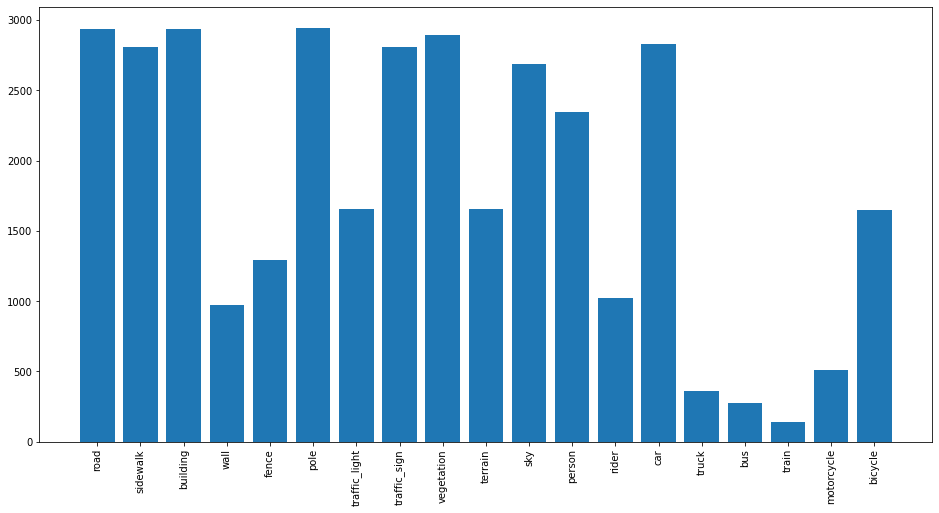

In [ ]:
# Visualizing label count 
arr=pd.DataFrame(df_train_labels.iloc[:,1:].sum(axis=0))
arr.columns=['labels']
arr.sort_values(by='labels',ascending=False)
plt.figure(figsize=(16,8))
plt.bar(arr.index,arr['labels'])
plt.xticks(rotation=90)
plt.show()

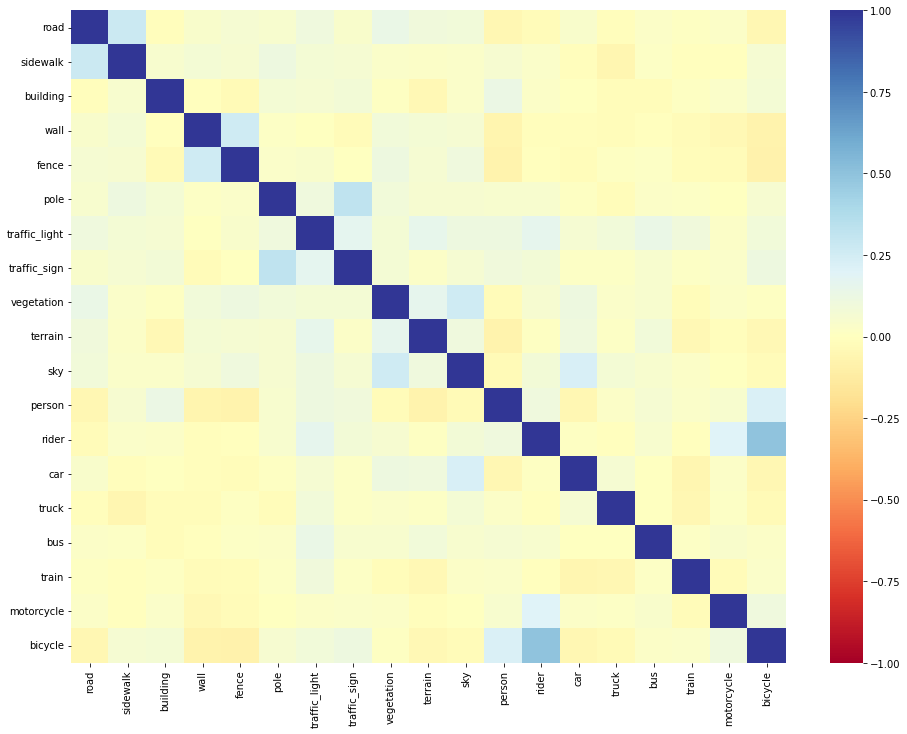

In [ ]:
# Looking for correlation between labels
import seaborn as sns
plt.figure(figsize=(16,12))
sns.heatmap(df_train_labels.iloc[:,1:].corr(), cmap="RdYlBu", vmin=-1, vmax=1)

In [14]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor

In [15]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from torchvision import models
import multiprocessing
import torchmetrics
import torch
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    self.layer = models.resnet18(pretrained = False)
    self.num_final_in = self.layer.fc.in_features
    NUM_CLASSES = 20
    self.layer.fc = nn.Linear(self.num_final_in, NUM_CLASSES)



  #parameters
    self.lr=1e-3
    self.batch_size=32
    self.numworker=multiprocessing.cpu_count()//4
    self.criterion=nn.BCEWithLogitsLoss()
    self.metrics = torchmetrics.Accuracy(num_classes=n_classes,mdmc_reduce='global')
    
    self.train_class = LabelClass('/content/drive/MyDrive/Colab_Notebooks/Summer 2022 Research/data/', split='train', mode='fine',
                     target_type='semantic',transforms=transform)
    self.val_class = LabelClass('/content/drive/MyDrive/Colab_Notebooks/Summer 2022 Research/data/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)  
    
  def forward(self,x):
    return self.layer(x)

  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    return DataLoader(self.train_class, batch_size=self.batch_size, 
                      shuffle=True,num_workers=self.numworker,pin_memory=True)

  def training_step(self,batch,batch_idx):
    image,segment=batch    
    loss=self.criterion(self(image),segment.float())
    self.log('train_loss', loss,on_step=True, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(self.val_class, batch_size=self.batch_size, 
                      shuffle=False,num_workers=self.numworker,pin_memory=True)
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    loss=self.criterion(self(image),segment.float())
    self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
    return loss

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
model = OurModel()
# checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',
#                                         filename='file',save_last=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model

In [ ]:
from pytorch_lightning.callbacks import RichProgressBar

# trainer = Trainer(callbacks=[RichProgressBar()])

trainer = Trainer(max_epochs=10, auto_lr_find=False, auto_scale_batch_size=False,
                  gpus=-1,precision=16,
                  callbacks=[RichProgressBar()] 
                 )

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# trainer = Trainer(max_epochs=20, auto_lr_find=False, auto_scale_batch_size=False,
#                   gpus=-1,precision=16,
#                   callbacks=[checkpoint_callback] 
#                  )

In [ ]:
trainer.fit(model)



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ layer     │ ResNet            │ 11.2 M │
│ 1 │ criterion │ BCEWithLogitsLoss │      0 │
│ 2 │ metrics   │ Accuracy          │      0 │
└───┴───────────┴───────────────────┴────────┘

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 22

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
save_path = '/content/drive/MyDrive/Model/'
torch.save(model.state_dict(),save_path + 'model.pth')

In [ ]:
import shutil, errno

def copyanything(src, dst):
    try:
        shutil.copytree(src, dst)
    except OSError as exc: # python >2.5
        if exc.errno in (errno.ENOTDIR, errno.EINVAL):
            shutil.copy(src, dst)
        else: raise


In [ ]:
copyanything('/content/lightning_logs','/content/drive/MyDrive/lightning_logs/')

In [ ]:
# from google.colab import files
# files.download('/content/lightning_logs')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# model = OurModel()
# checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',
#                                         filename='file',save_last=True)

In [ ]:
# torch.save(model.state_dict(), 'model.pth')

In [17]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/model.pth'))

<All keys matched successfully>

In [18]:
test_class = LabelClass('/content/drive/MyDrive/Colab_Notebooks/Summer 2022 Research/data/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader=DataLoader(test_class, batch_size=12, 
                      shuffle=False)

In [19]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        output=model(img)
        break
print(img.shape,seg.shape,output.shape)    

torch.Size([12, 3, 224, 224]) torch.Size([12, 20]) torch.Size([12, 20])


In [ ]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)


In [21]:
train_dl= LabelClass('/content/drive/MyDrive/Colab_Notebooks/Summer 2022 Research/data/', split='train', mode='fine',
                     target_type='semantic',transforms=transform)
img,seg= train_dl[469]

In [ ]:
img,seg

(tensor([[[-1.5870, -1.5699, -1.5870,  ..., -1.1760, -1.2445, -1.2274],
          [-1.5699, -1.5014, -1.4843,  ..., -1.5014, -1.4843, -1.4672],
          [-1.5014, -1.5014, -1.4500,  ..., -0.9192, -0.9020, -0.9192],
          ...,
          [-1.1418, -1.1760, -1.2274,  ..., -1.3302, -1.3987, -1.3644],
          [-1.1932, -1.2788, -1.3473,  ..., -1.3302, -1.3815, -1.3815],
          [-1.3644, -1.3815, -1.3302,  ..., -1.3815, -1.3644, -1.3815]],
 
         [[-1.2129, -1.2304, -1.2654,  ..., -0.8452, -0.8978, -0.8978],
          [-1.2129, -1.1078, -1.0553,  ..., -1.2304, -1.2304, -1.2129],
          [-1.1604, -1.1429, -1.0378,  ..., -0.5126, -0.5126, -0.5651],
          ...,
          [-0.7052, -0.7752, -0.7927,  ..., -0.9678, -1.0203, -1.0028],
          [-0.7927, -0.8978, -0.9503,  ..., -0.9678, -1.0028, -1.0203],
          [-0.9503, -0.9678, -0.9678,  ..., -1.0203, -1.0203, -1.0203]],
 
         [[-1.2641, -1.2293, -1.2467,  ..., -0.8284, -0.8807, -0.8633],
          [-1.2293, -1.1247,

In [22]:
print(img.shape,seg.shape)

torch.Size([3, 224, 224]) torch.Size([20])


In [ ]:
test_dl= LabelClass('/content/drive/MyDrive/Colab_Notebooks/Summer 2022 Research/data/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)

In [ ]:
model = OurModel.load_from_checkpoint("/content/file.ckpt")

model.eval()

OurModel(
  (layer): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [23]:
# predict with the model

y_hat = model(img.unsqueeze(0))

In [24]:
y_hat

tensor([[18.1559,  5.9430,  3.5259,  7.9915, -1.6500, -0.8606,  9.0116,  1.5766,
          4.8530,  7.1134,  1.9115,  2.4587,  3.0550,  0.2440,  4.7054, -1.8131,
         -2.2597, -3.3625, -0.9460,  1.7491]], grad_fn=<AddmmBackward0>)

converting y_hat to thresholds

In [30]:
threshold = torch.tensor([0])

results = (y_hat>threshold).float()*1
print(results)

tensor([[1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 1.]])


In [25]:
seg

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0])